# 设计Echart版本的ec数据读取形式

In [ ]:
# 原始代码

In [15]:
import geopandas as gpd
import matplotlib.pyplot as plt
import netCDF4
import numpy as np
# import modin.pandas as pd
import pandas as pd
import shapefile
import xarray as xr
from affine import Affine
from matplotlib.patches import PathPatch
from matplotlib.path import Path
from mpl_toolkits.basemap import Basemap
from ncmaps import Cmaps
from rasterio import features
import xesmf as xe
import redis
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
# import h5netcdf.legacyapi as netCDF4
import os
os.environ["HDF5_USE_FILE_LOCKING"] = 'FALSE'
import datetime as dtt
from datetime import *
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

from pylab import *
from matplotlib.font_manager import FontProperties
import pymysql
import pandas as pd
from sqlalchemy import create_engine




# ec数据的处理和对接
class ec_data_point:
    def __init__(self,start_time,end_time):
        self.timelist = [0,2,4,6,8,10,12,14,16,18,20,22,24,25,
                         26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,
                        41,42,43,44,45,46,47,48,49,50,51,52]
        self.test_time = '2022041700'
        self.file_path = "/home/workspace/Data/My_Git/" + self.test_time + "/" 
        self.lat_list = [27.6, 28.1, 28.4, 29.1, 29.1, 29.8, 28.7, 28.5, 28.5, 28.6]
        self.lon_list = [120.7, 121.1, 121.3, 121.2, 121.0, 120.7, 121.1, 121.4, 121.4, 121.2]
        self.exlat = [120.2,122.3,121.8]
        self.exlon = [27.1,28.5,30.6]
        self.name = ["台州", "玉环", "温岭", "三门", "天台", "仙居", "临海", "路桥", "椒江", "黄岩"]
        self.name_en = ['taizhou','yuhuan','wenling','sanmen','tiantai','xianju','linhai','luqiao','jiaojiang','huangyan']
        self.cp,self.t2,self.tp = self.read_data()
    # 外部函数
    def transform_from_latlon(self,lat, lon):
        lat = np.asarray(lat)
        lon = np.asarray(lon)
        trans = Affine.translation(lon[0], lat[0])
        scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
        return trans * scale    
    def rasterize(self,shapes, coords, latitude='lat', longitude='lon',fill=np.nan, **kwargs):
        transform = self.transform_from_latlon(coords[latitude], coords[longitude])
        out_shape = (len(coords[latitude]), len(coords[longitude]))
        raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
        spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
        return xr.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))
    def add_shape_coord_from_data_array(self,xr_da, shp_path, coord_name):   
        shp_gpd = gpd.read_file(shp_path)
        shapes = [(shape, n) for n, shape in enumerate(shp_gpd.geometry)]
        xr_da[coord_name] = self.rasterize(shapes, xr_da.coords, longitude='lon', latitude='lat')
        return xr_da
    def regrid(self,data):
        # 插值
        ds_out = xr.Dataset(
            {   
                
                "lat": (["lat"], np.arange(27.0, 31, 0.05)),
                "lon": (["lon"], np.arange(120, 122.9, 0.05)),
            }
        )
        regridder = xe.Regridder(data, ds_out, "bilinear")
        dr_out = regridder(data)
        return dr_out
    # 读取数据
    def read_data(self):
        '''读取数据'''
        files = os.listdir(self.file_path)
        tp_list = [] 
        cp_list = [] 
        t2_list = [] 
        for fileitem in self.timelist:
            f=xr.open_dataset(self.file_path +files[fileitem],decode_times=False)
            tp = f.tp.sel(lonS=slice(118,123),latS=slice(32,26))
            cp = f.cp.sel(lonS=slice(118,123),latS=slice(32,26))
            t2 = f.t2.sel(lonS=slice(118,123),latS=slice(32,26)) 
            tp_list.append(tp)  
            cp_list.append(cp)  
            t2_list.append(t2)
            del f,tp,cp,t2  
        cp_all = xr.concat(cp_list,dim="time")
        cp_all = self.regrid(cp_all)
        t2_all = xr.concat(t2_list,dim="time")
        t2_all = self.regrid(t2_all)
        tp_all = xr.concat(tp_list,dim="time")
        tp_all = self.regrid(tp_all)
        return cp_all,t2_all,tp_all
    # 曲线的读取
    def accum_data(self,list_data):
        '''处理累计降水'''
        out_list = []
        for i in range(len(list_data)):
            if i==0:
                out_list.append(0)
            elif i==1:
                out_list.append(round(list_data[i],1))
            else:
                out_list.append(round(list_data[i]-list_data[i-1],1))
        return out_list
    def rain_data(self,lat,lon,data):
        list_data= data.sel(lon=lon, lat=lat,method='nearest').to_pandas().tolist()
        out_list = self.accum_data(list_data)
        return out_list
    def plot_line(self,lat,lon):
        '''返回单点的降水气温曲线图'''
        cp_line = self.rain_data(lat,lon,self.cp)
        totle_line = self.rain_data(lat,lon,self.tp)
        tp_line = []
        for i in range(len(totle_line)):
            tp_line.append(totle_line[i] - cp_line[i])
        t2_line = self.t2.sel(lon=lon, lat=lat,method='nearest').to_pandas().tolist()
        return cp_line,tp_line,t2_line
    def conuty_data(self):
        '''将数据整理成json并存储到MySQL'''
        data_list = []
        for i in range(len(self.lat_list)):
            lat = self.lat_list[i]
            lon = self.lon_list[i]
            cp_line,tp_line,t2_line = self.plot_line(lat,lon)
            cp = [0 if np.isnan(x) else x for x in cp_line]
            tp = [0 if np.isnan(x) else x for x in tp_line]
            t2 = [0 if np.isnan(x) else x for x in t2_line]
            data_single = {
                "name":self.name_en[i],
                "cp":cp,
                "tp":tp,
                "t2":t2
            }
            data_list.append(data_single)
        return data_list
    # 定时任务
    def to_sql(self):
        '''将数据传到sql中'''
        pass
    # 截面数据的读取
    def rander_leaflet(self,start_time,end_time):
        '''返回数据'''
        if start_time==0:
            rain = end_rain 
        else:
            start_rain = self.tp[start_time,:,:]
            end_rain = self.tp[end_time,:,:]
            rain = end_rain - start_rain 
        filepath = "shpfile/"
        shp_da = self.add_shape_coord_from_data_array(rain, filepath+"taizhou.shp", "remain") 
        taizhou = shp_da.where(shp_da.remain<7, other=99999)
        len_lat = len(taizhou.lat.data)
        len_lon = len(taizhou.lon.data)
        data = []
#         print(rain)
        for j in range(len(self.exlat)):
            exlat = self.exlat[j]
            exlon = self.exlon[j]
            value = rain.sel(lon=exlon, lat=exlat,method='nearest').to_pandas().tolist()
            print(type(value),value)
            exsingle =  {
                "type": "Feature",
                "properties": {
                "value": str(value)},
                "geometry": {
                    "type": "Point",
                    "coordinates": [exlon, exlat]
                }
            }
            data.append(exsingle) 
        for i in range(len_lon-1):
            for j in range(len_lat-1):
                y0 = taizhou.lat.data[j]
                x0 = taizhou.lon.data[i]
                if taizhou.data[j, i]!=99999:
                    single = {
                        "type": "Feature",
                        "properties": {
                            "value": str(taizhou.data[j, i])
                        },
                        "geometry": {
                            "type": "Point",
                            "coordinates": [x0, y0]
                        }
                    }
                    data.append(single)  
        return data

start_time,end_time = 1,24
ec_worker = ec_data_point(start_time,end_time) 
data = ec_worker.rander_leaflet(start_time,end_time)

/opt/conda/lib/python3.7/site-packages/xarray/core/dataarray.py:784: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


<class 'float'> 0.0
<class 'float'> 0.0
<class 'float'> 0.0


# 同步EC数据的代码

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import netCDF4
import numpy as np
# import modin.pandas as pd
import pandas as pd
import shapefile
import xarray as xr
from affine import Affine
from matplotlib.patches import PathPatch
from matplotlib.path import Path
from mpl_toolkits.basemap import Basemap
from ncmaps import Cmaps
from rasterio import features

import xesmf as xe
import redis
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
# import h5netcdf.legacyapi as netCDF4
import os
os.environ["HDF5_USE_FILE_LOCKING"] = 'FALSE'
import datetime as dtt
from datetime import *
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

from pylab import *
from matplotlib.font_manager import FontProperties
import pymysql
from  sqlalchemy import  create_engine
from pymysql.converters import escape_string
# 数据库

import json
from django.db import connection

class ec_data_upload:
    def __init__(self):
        self.timelist = [0,2,4,6,8,10,12,14,16,18,20,22,24,25,
                         26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,
                        41,42,43,44,45,46,47,48,49,50,51,52]
        self.date_time = self.time_file()
        self.file_path = "/home/liyuan3970/Data/My_Git/" + self.date_time + "/" 
        self.lat_list = [28.62, 28.1, 28.4, 29.1, 29.1, 29.8, 28.7, 28.5, 28.5, 28.6]
        self.lon_list = [121.42, 121.1, 121.3, 121.2, 121.0, 120.7, 121.1, 121.4, 121.4, 121.2]
        self.name = ["台州", "玉环", "温岭", "三门", "天台", "仙居", "临海", "路桥", "椒江", "黄岩"]
        self.name_en = ['taizhou','yuhuan','wenling','sanmen','tiantai','xianju','linhai','luqiao','jiaojiang','huangyan']
        self.cp,self.t2,self.tp = self.read_data()
    def regrid(self,data):
        # 插值
        ds_out = xr.Dataset(
            {   
                
                "lat": (["lat"], np.arange(27.0, 31, 0.05)),
                "lon": (["lon"], np.arange(120, 122.9, 0.05)),
            }
        )
        regridder = xe.Regridder(data, ds_out, "bilinear")
        dr_out = regridder(data)
        return dr_out
    def time_file(self):
        today = dtt.date.today()
        yesterday = today - dtt.timedelta(days = 1) 
        year = yesterday.strftime('%Y-%m-%d_%H%M%S')[0:4]
        month =  yesterday.strftime('%Y-%m-%d_%H%M%S')[5:7]
        day = yesterday.strftime('%Y-%m-%d_%H%M%S')[8:10]
        file_time = year + month + day + "00"
        #file_time = '2022041700'
        file_time = '2023050612'
        return file_time      
    def read_data(self):
        '''读取数据'''
        files = os.listdir(self.file_path)
        tp_list = [] 
        cp_list = [] 
        t2_list = [] 
        for fileitem in self.timelist:
            f=xr.open_dataset(self.file_path +files[fileitem],decode_times=False)
            tp = f.tp.sel(lonS=slice(118,123),latS=slice(32,26))
            cp = f.cp.sel(lonS=slice(118,123),latS=slice(32,26))
            t2 = f.t2.sel(lonS=slice(118,123),latS=slice(32,26)) 
            tp_list.append(tp)  
            cp_list.append(cp)  
            t2_list.append(t2)
            del f,tp,cp,t2  
        cp_all = xr.concat(cp_list,dim="time")
        cp_all = self.regrid(cp_all)
        t2_all = xr.concat(t2_list,dim="time")
        t2_all = self.regrid(t2_all)
        tp_all = xr.concat(tp_list,dim="time")
        tp_all = self.regrid(tp_all)
        return cp_all,t2_all,tp_all
    def accum_data(self,list_data):
        '''处理累计降水'''
        out_list = []
        for i in range(len(list_data)):
            if i==0:
                out_list.append(0)
            elif i==1:
                out_list.append(round(list_data[i],1))
            else:
                out_list.append(round(list_data[i]-list_data[i-1],1))
        return out_list
    def rain_data(self,lat,lon,data):
        list_data= data.sel(lon=lon, lat=lat,method='nearest').to_pandas().tolist()
        out_list = self.accum_data(list_data)
        return out_list
    def plot_line(self,lat,lon):
        '''返回单点的降水气温曲线图'''
        cp_line = self.rain_data(lat,lon,self.cp)
        totle_line = self.rain_data(lat,lon,self.tp)
        tp_line = []
        for i in range(len(totle_line)):
            tp_line.append(totle_line[i] - cp_line[i])
        t2_line = self.t2.sel(lon=lon, lat=lat,method='nearest').to_pandas().tolist()
        return cp_line,tp_line,t2_line
    def conuty_data(self):
        '''将数据整理成json并存储到MySQL'''
        data_list = []
        mysql_setting = {
            'host': '127.0.0.1',
            'port': 3306,
            'user': 'root',
            'passwd': '051219',
            # 数据库名称
            'db': 'tzweb',
            'charset': 'utf8'
        }
        mydb =pymysql.connect(
            host="127.0.0.1",
            user="root",
            password="051219",
            database="tzweb"
        )
        for i in range(len(self.lat_list)):
            lat = self.lat_list[i]
            lon = self.lon_list[i]
            cp_line,tp_line,t2_line = self.plot_line(lat,lon)
            cp = [0 if np.isnan(x) else x for x in cp_line]
            tp = [0 if np.isnan(x) else x for x in tp_line]
            t2 = [0 if np.isnan(x) else x for x in t2_line]
            data_single = {
                'name':self.name_en[i],
                'cp':cp,
                'tp':tp,
                't2':t2
            }
            data_list.append(data_single)
        # 数据库插入数据
        create_time = dtt.date.today()
        update_time = dtt.date.today()
        time = self.date_time
        model_type = "EC"
        model_city ="台州市" #self.name_en[i]
        data = json.dumps(data_list)
        create_user=0
        update_user=0
        cursor = mydb.cursor()
        sql = '''insert INTO ec_data(create_time,update_time,model_type,model_city,time,create_user,update_user,data) values ('{create_time}','{update_time}','{model_type}','{model_city}','{time}',0,0,'{data}') '''            
        #sql = '''replace into ec_data(model_type,model_city,time,create_user,update_user,data) select '{model_type}','{model_city}','{time}',0,0,'{data}'  '''  
        rsql = sql.format(create_time=create_time,update_time=update_time,model_type=model_type,model_city=model_city,time=time,create_user=create_user,update_user=update_user,data=escape_string(data)) 
        cursor.execute(rsql)               
        mydb.commit()
        cursor.close()
        mydb.close()
        return data_list
    # 定时任务
    def to_sql(self):
        '''将数据传到sql中'''
        print("数据上传")
        data = self.conuty_data()
    
ec_worker = ec_data_upload() 
data = ec_worker.conuty_data()

# 查询数据的方法

In [25]:
import geopandas as gpd
import matplotlib.pyplot as plt
import netCDF4
import numpy as np
# import modin.pandas as pd
import pandas as pd
import shapefile
import xarray as xr
from affine import Affine
from matplotlib.patches import PathPatch
from matplotlib.path import Path
from mpl_toolkits.basemap import Basemap
from ncmaps import Cmaps
from rasterio import features



import xesmf as xe
import redis
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
# import h5netcdf.legacyapi as netCDF4

os.environ["HDF5_USE_FILE_LOCKING"] = 'FALSE'
import datetime as dtt
from datetime import *
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

from pylab import *
from matplotlib.font_manager import FontProperties
import pymysql
import pandas as pd
from sqlalchemy import create_engine




# ec数据的处理和对接
class ec_data_point:
    def __init__(self,start_time,end_time):
        self.timelist = [0,2,4,6,8,10,12,14,16,18,20,22,24,25,
                         26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,
                        41,42,43,44,45,46,47,48,49,50,51,52]
        self.test_time = '2022041700'
        self.file_path = "/home/liyuan3970/Data/My_Git/" + self.test_time + "/" 
        self.cp,self.t2,self.tp = self.read_data()
    # 外部函数
    def transform_from_latlon(self,lat, lon):
        lat = np.asarray(lat)
        lon = np.asarray(lon)
        trans = Affine.translation(lon[0], lat[0])
        scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
        return trans * scale    
    def rasterize(self,shapes, coords, latitude='lat', longitude='lon',fill=np.nan, **kwargs):
        transform = self.transform_from_latlon(coords[latitude], coords[longitude])
        out_shape = (len(coords[latitude]), len(coords[longitude]))
        raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
        spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
        return xr.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))
    def add_shape_coord_from_data_array(self,xr_da, shp_path, coord_name):   
        shp_gpd = gpd.read_file(shp_path)
        shapes = [(shape, n) for n, shape in enumerate(shp_gpd.geometry)]
        xr_da[coord_name] = self.rasterize(shapes, xr_da.coords, longitude='lon', latitude='lat')
        return xr_da
    def regrid(self,data):
        # 插值
        ds_out = xr.Dataset(
            {   
                
                "lat": (["lat"], np.arange(27.0, 31, 0.05)),
                "lon": (["lon"], np.arange(120, 122.9, 0.05)),
            }
        )
        regridder = xe.Regridder(data, ds_out, "bilinear")
        dr_out = regridder(data)
        return dr_out
    # 读取数据
    def read_data(self):
        '''读取数据'''
        files = os.listdir(self.file_path)
        tp_list = [] 
        cp_list = [] 
        t2_list = [] 
        for fileitem in self.timelist:
            f=xr.open_dataset(self.file_path +files[fileitem],decode_times=False)
            tp = f.tp.sel(lonS=slice(118,123),latS=slice(32,26))
            cp = f.cp.sel(lonS=slice(118,123),latS=slice(32,26))
            t2 = f.t2.sel(lonS=slice(118,123),latS=slice(32,26)) 
            tp_list.append(tp)  
            cp_list.append(cp)  
            t2_list.append(t2)
            del f,tp,cp,t2  
        cp_all = xr.concat(cp_list,dim="time")
        cp_all = self.regrid(cp_all)
        t2_all = xr.concat(t2_list,dim="time")
        t2_all = self.regrid(t2_all)
        tp_all = xr.concat(tp_list,dim="time")
        tp_all = self.regrid(tp_all)
        return cp_all,t2_all,tp_all
    def read_sql(self):
        '''将数据传到sql中'''
        time = '2022041700'
        mydb =pymysql.connect(
            host="127.0.0.1",
            user="root",
            password="051219",
            database="tzweb"
        )
        sql="""select data from  ec_data order by create_time"""
        data=pd.read_sql(sql,mydb)
        # 数据转为python类型
        data_org = data.iloc[0].data
        data_python = json.loads(data_org)
        return data_python
    def rander_leaflet(self,start_time,end_time):
        '''返回数据'''
        if start_time==0:
            rain = end_rain 
        else:
            start_rain = self.tp[start_time,:,:]
            end_rain = self.tp[end_time,:,:]
            rain = end_rain - start_rain 
        filepath = "shpfile/"
        shp_da = self.add_shape_coord_from_data_array(rain, filepath+"taizhou.shp", "remain") 
        taizhou = shp_da.where(shp_da.remain<7, other=99999)
        len_lat = len(taizhou.lat.data)
        len_lon = len(taizhou.lon.data)
        data = []
        for i in range(len_lon-1):
            for j in range(len_lat-1):
                y0 = taizhou.lat.data[j]
                x0 = taizhou.lon.data[i]
                if taizhou.data[j, i]!=99999:
                    single = {
                        "type": "Feature",
                        "properties": {
                            "value": str(taizhou.data[j, i])
                        },
                        "geometry": {
                            "type": "Point",
                            "coordinates": [x0, y0]
                        }
                    }
                    data.append(single)  
        return data

start_time,end_time = 1,24
ec_worker = ec_data_point(start_time,end_time) 
data = ec_worker.read_sql()
print("ok")

/opt/conda/lib/python3.7/site-packages/xarray/core/dataarray.py:784: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


ok


# 加载为python格式的数据

In [ ]:
a= data.iloc[0].data
b= json.loads(a)
b

In [4]:
a= data.iloc[0].data
b= json.loads(a)

AttributeError: 'dict' object has no attribute 'iloc'

In [29]:
%%time
import datetime as dtt
import xarray as xr 
import os
import numpy as np
import xesmf as xe
import redis
import pandas as pd
def upload_ec_data(): 
    lat_list = [27.6, 28.1, 28.4, 29.1, 29.1, 29.8, 28.7, 28.5, 28.5, 28.6]
    lon_list = [120.7, 121.1, 121.3, 121.2, 121.0, 120.7, 121.1, 121.4, 121.4, 121.2]
    timelist = [0,2,4,6,8,10,12,14,16,18,20,22,24,25,
                         26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,
                        41,42,43,44,45,46,47,48,49,50,51,52]
    name = ["台州", "玉环", "温岭", "三门", "天台", "仙居", "临海", "路桥", "椒江", "黄岩"]
    name_en = ['taizhou','yuhuan','wenling','sanmen','tiantai','xianju','linhai','luqiao','jiaojiang','huangyan']
    today = dtt.date.today()
    yesterday = today - dtt.timedelta(days = 1) 
    year = yesterday.strftime('%Y-%m-%d_%H%M%S')[0:4]
    month =  yesterday.strftime('%Y-%m-%d_%H%M%S')[5:7]
    day = yesterday.strftime('%Y-%m-%d_%H%M%S')[8:10]
    file_time = year + month + day + "00"
    file_time = '2022041700'
    file_path = "/workspace/liyuan3970/Data/My_Git/" + file_time + "/"
    ds_out = xr.Dataset(
        {   
                
            "lat": (["lat"], np.arange(27.0, 31, 0.05)),
            "lon": (["lon"], np.arange(120, 122.9, 0.05)),
        }
    )
    # 读取数据
    files = os.listdir(file_path)
    tp_list = [] 
    cp_list = [] 
    t2_list = [] 
    for fileitem in timelist:
        f=xr.open_dataset(file_path +files[fileitem],decode_times=False)
        tp = f.tp.sel(lonS=slice(118,123),latS=slice(32,26))
        cp = f.cp.sel(lonS=slice(118,123),latS=slice(32,26))
        t2 = f.t2.sel(lonS=slice(118,123),latS=slice(32,26))
        tp_list.append(tp)  
        cp_list.append(cp)  
        t2_list.append(t2)
        del f,tp,cp,t2 
    cp_all = xr.concat(cp_list,dim="time")
    t2_all = xr.concat(t2_list,dim="time")
    tp_all = xr.concat(tp_list,dim="time")
    # 数据差值
    regridder_cp = xe.Regridder(cp_all, ds_out, "bilinear")
    regridder_tp = xe.Regridder(tp_all, ds_out, "bilinear")
    regridder_t2 = xe.Regridder(t2_all, ds_out, "bilinear")
    dr_cp = regridder_cp(cp_all)
    dr_tp = regridder_tp(tp_all)
    dr_t2 = regridder_t2(t2_all)
    # 数据输出
    data_list = []
    for i in range(len(lat_list)):
        lat = lat_list[i]
        lon = lon_list[i]
        cp_line,tp_line,t2_line = plot_line(lat,lon)
        data_single = {
            "name":name_en[i],
            "cp":cp_line,
            "tp":tp_line,
            "t2":t2_line
        }
        data_list.append(data_single)
    print("上传数据",yesterday,file_time,file_path)



upload_ec_data()    

上传数据 2023-04-03 2022041700 /workspace/liyuan3970/Data/My_Git/2022041700/
CPU times: user 1.09 s, sys: 13.1 ms, total: 1.1 s
Wall time: 1.19 s


In [1]:
import geopandas as gpd


shp_path = "shpfile/xiangzhen/xiangzhen.shp"
shp_gpd = gpd.read_file(shp_path, encoding='utf8')
shp_gpd

/opt/conda/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


,FEATUREGUI,FCODE,NAME,FSCALE,USOURCE,UPDATETIME,UPDATESTAT,SHAPE_Leng,SHAPE_Area,COUNTY,SHI,TYPE,CITYCODE,geometry
0,3dd51852d9dc44f5ab5cb0004bd766bf,6601000500,安洲街道,13,20190402基础库全量包,20190402,U,0.542087,0.004292,仙居县,台州市,4,None,"POLYGON ((120.68685 28.91842, 120.68606 28.914..."
1,8425d006aeb34b858d86120247526bef,6601000500,桃渚镇,13,20190402基础库全量包,20190402,U,1.018298,0.011036,临海市,台州市,4,None,"MULTIPOLYGON (((121.67986 28.79381, 121.67952 ..."
2,03b8f0e160754d608c5747b467d7e5c8,6601000500,蓬街镇,13,20190402基础库全量包,20190402,U,0.511900,0.006772,路桥区,台州市,4,None,"MULTIPOLYGON (((121.60227 28.55373, 121.60217 ..."
3,094b7e3bcc3144329512958c9d6fc8be,6601000500,杜桥镇,13,20190402基础库全量包,20190402,U,0.900278,0.016811,临海市,台州市,4,None,"POLYGON ((121.47616 28.82388, 121.47818 28.823..."
4,91d31aae17484169a101b846138f620c,6601000500,海门街道,13,2020年6月基础库政区数据,20200611,U,0.302182,0.002189,椒江区,台州市,4,None,"POLYGON ((121.50494 28.66132, 121.49950 28.658..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,5b8d3b8c1b044a2c886155549a6d753c,6601000500,大陈镇,13,2020年6月基础库政区数据,20200611,A,1.231533,0.001371,椒江区,台州市,4,None,"MULTIPOLYGON (((121.90887 28.39064, 121.90949 ..."
127,ab5f6c265fba43559d1cf7838a08a727,6601000500,城南镇,13,2020年6月基础库政区数据,20200611,A,1.055532,0.010046,温岭市,台州市,4,None,"MULTIPOLYGON (((121.43654 28.26580, 121.43835 ..."
128,566991a69fc24be5845186e4678c735a,6601000500,花桥镇,13,2020年6月基础库政区数据,20200611,A,0.569683,0.006595,三门县,台州市,4,None,"MULTIPOLYGON (((121.56132 28.93053, 121.56174 ..."
129,d19857af684e40f0ad5b03a2690f2765,6601000500,新桥镇,13,20190402基础库全量包,20190402,U,0.233467,0.001272,路桥区,台州市,4,None,"POLYGON ((121.42574 28.53229, 121.43003 28.525..."


# Leaflet版本的ec数据

In [1]:
%%time
import geopandas as gpd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
import xesmf as xe
import redis
import pandas as pd
import datetime
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import os
import random
from io import BytesIO
import base64
from rasterio import features
from affine import Affine



class ec_data_point:
    def __init__(self,start_time,end_time):
        self.timelist = [0,2,4,6,8,10,12,14,16,18,20,22,24,25,
                         26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,
                        41,42,43,44,45,46,47,48,49,50,51,52]
        self.test_time = '2022041700'
        self.file_path = "/workspace/liyuan3970/Data/My_Git/" + self.test_time + "/" 
        self.lat_list = [27.6, 28.1, 28.4, 29.1, 29.1, 29.8, 28.7, 28.5, 28.5, 28.6]
        self.lon_list = [120.7, 121.1, 121.3, 121.2, 121.0, 120.7, 121.1, 121.4, 121.4, 121.2]
        self.name = ["台州", "玉环", "温岭", "三门", "天台", "仙居", "临海", "路桥", "椒江", "黄岩"]
        self.name_en = ['taizhou','yuhuan','wenling','sanmen','tiantai','xianju','linhai','luqiao','jiaojiang','huangyan']
        self.read_data()
        #self.cp,self.t2,self.tp = self.read_data()
    # 外部函数
    def transform_from_latlon(self,lat, lon):
        lat = np.asarray(lat)
        lon = np.asarray(lon)
        trans = Affine.translation(lon[0], lat[0])
        scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
        return trans * scale    
    def rasterize(self,shapes, coords, latitude='lat', longitude='lon',fill=np.nan, **kwargs):
        transform = self.transform_from_latlon(coords[latitude], coords[longitude])
        out_shape = (len(coords[latitude]), len(coords[longitude]))
        raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
        spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
        return xr.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))
    def add_shape_coord_from_data_array(self,xr_da, shp_path, coord_name):   
        shp_gpd = gpd.read_file(shp_path)
        shapes = [(shape, n) for n, shape in enumerate(shp_gpd.geometry)]
        xr_da[coord_name] = self.rasterize(shapes, xr_da.coords, longitude='lon', latitude='lat')
        return xr_da
    def regrid(self,data):
        # 插值
        ds_out = xr.Dataset(
            {   
                
                "lat": (["lat"], np.arange(27.0, 30, 0.05)),
                "lon": (["lon"], np.arange(120, 122.5, 0.05)),
            }
        )
        regridder = xe.Regridder(data, ds_out, "bilinear")
        dr_out = regridder(data)
        return dr_out
    # 读取数据
    def read_data(self):
        '''读取数据'''
        files = os.listdir(self.file_path)
        tp_list = [] 
        cp_list = [] 
        t2_list = [] 
        f=xr.open_dataset("/workspace/liyuan3970/Data/My_Git/2022041700/ecfine.I2022041700.000.F2022041700.nc",decode_times=False)
#         for fileitem in self.timelist:
#             datapath = self.file_path + str(files[fileitem])
#             print("数据",type(fileitem),type(self.file_path),type(files[fileitem]),type(datapath),datapath)           
#             f=xr.open_dataset(datapath,decode_times=False)
#             tp = f.tp.sel(lonS=slice(118,123),latS=slice(32,26))
#             #tp = tp.swap_dims({'latS':'lat','lonS':'lon'})
#             cp = f.cp.sel(lonS=slice(118,123),latS=slice(32,26))
#             #cp = cp.swap_dims({'latS':'lat','lonS':'lon'})
#             t2 = f.t2.sel(lonS=slice(118,123),latS=slice(32,26)) 
#             #t2 = t2.swap_dims({'latS':'lat','lonS':'lon'})
#             tp_list.append(tp)  
#             cp_list.append(cp)  
#             t2_list.append(t2)
#             del f,tp,cp,t2  
#         cp_all = xr.concat(cp_list,dim="time")
#         #cp_all = self.regrid(cp_all)
#         t2_all = xr.concat(t2_list,dim="time")
#         #t2_all = self.regrid(t2_all)
#         tp_all = xr.concat(tp_list,dim="time")
#         #tp_all = self.regrid(tp_all)
#         return cp_all,t2_all,tp_all
    # 曲线的读取
    def accum_data(self,list_data):
        '''处理累计降水'''
        out_list = []
        for i in range(len(list_data)):
            if i==0:
                out_list.append(0)
            elif i==1:
                out_list.append(round(list_data[i],1))
            else:
                out_list.append(round(list_data[i]-list_data[i-1],1))
        return out_list
    def rain_data(self,lat,lon,data):
        list_data= data.sel(lon=lon, lat=lat,method='nearest').to_pandas().tolist()
        out_list = self.accum_data(list_data)
        return out_list
    def plot_line(self,lat,lon):
        '''返回单点的降水气温曲线图'''
        cp_line = self.rain_data(lat,lon,self.cp)
        totle_line = self.rain_data(lat,lon,self.tp)
        tp_line = []
        for i in range(len(totle_line)):
            tp_line.append(totle_line[i] - cp_line[i])
        t2_line = self.t2.sel(lon=lon, lat=lat,method='nearest').to_pandas().tolist()
        return cp_line,tp_line,t2_line
    def conuty_data(self):
        '''将数据整理成json并存储到MySQL'''
        data_list = []
        for i in range(len(self.lat_list)):
            lat = self.lat_list[i]
            lon = self.lon_list[i]
            cp_line,tp_line,t2_line = self.plot_line(lat,lon)
            data_single = {
                "name":self.name_en[i],
                "cp":cp_line,
                "tp":tp_line,
                "t2":t2_line
            }
            data_list.append(data_single)
        return data_list
    # 定时任务
    def to_sql(self):
        '''将数据传到sql中'''
        pass
    # 截面数据的读取
    def rander_leaflet(self,start_time,end_time):
        '''返回数据'''
        if start_time==0:
            rain = end_rain 
        else:
            start_rain = self.tp[start_time,:,:]
            end_rain = self.tp[end_time,:,:]
            rain = end_rain - start_rain 
        filepath = "static/data/shpfile/"
        shp_da = self.add_shape_coord_from_data_array(rain, filepath+"taizhou.shp", "remain") 
        taizhou = shp_da.where(shp_da.remain<7, other=0.0)
        len_lat = len(taizhou.lat.data)
        len_lon = len(taizhou.lon.data)
        data = []
        for i in range(len_lon-1):
            for j in range(len_lat-1):
                #y0 = round(27.00+j*0.05,2)
                #x0 = round(120.00+i*0.05,2)
                y0 = taizhou.lat.data[j]
                x0 = taizhou.lon.data[i]
                if taizhou.data[j, i]!=0:
                    # single = {
                    #     "Lat":y0,
                    #     "Lon":x0,
                    #     "value":str(taizhou.data[j, i])
                    # }
                    single = {
                        "type": "Feature",
                        "properties": {
                            "value": str(taizhou.data[j, i])
                        },
                        "geometry": {
                            "type": "Point",
                            "coordinates": [x0, y0]
                        }
                    }
                    data.append(single)  
        return data
    
start_time,end_time = 1,24
ec_worker = ec_data_point(start_time,end_time) 
# ec_worker.rander_leaflet(start_time,end_time) 
# ec_worker.plot_line(27.532,121.932)
# ec_worker.rander_leaflet(start_time,end_time)
# a = ec_worker.comput_average(start_time,end_time)


/opt/conda/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


TypeError: expected string or bytes-like object

In [3]:
ec_worker.cp

<xarray.DataArray (time: 41, lat: 60, lon: 50)>
array([[[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        ...,
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
...
        [6.9407783e+00, 6.4130440e+00, 5.8857985e+00, ...,
         4.7254655e-01, 4.0662104e-01, 4.5056763e-01],
        [7.3253598e+00, 6.7248130e+00, 6.1240396e+00, ...,
         3.9187646e-01, 3.5889715e-01, 5.2732444e-01],
        [6.5928240e+00, 6.2559905e+00, 5.9189296e+00, ...,
         5.5303431e-01, 6.0063392e-01, 8.8626689e-01]],

       [[5.2651028e+01, 5.4922379e+01, 5.7193703e+01, ...,
         4.0162216e+01, 4.0143833e+01, 4.0766552e+01],
        [5.3749832e+01, 5.3632969e+01, 5.3516068e+01, ...,
         3.8344917e+01, 3.8099560e+01, 3.7931465e+01],
        [5.4848637e+01, 5.2343704e+01, 4.9838741e+01, ...,
         3.6528233e+01, 3.6055786e+01, 3.5096554e+01],
        ...,
        [6.9407783e+00, 6.4789681e+00, 6.0176497e+00, ...,
         4.7254655e-01, 4.0662104e-01, 4.5056763e-01],
        [7.3253598e+00, 6.7907453e+00, 6.2559018e+00, ...,
         3.9187646e-01, 3.5889715e-01, 5.2732444e-01],
        [6.5928240e+00, 6.3072720e+00, 6.0214906e+00, ...,
         5.5303431e-01, 6.0063392e-01, 8.8626689e-01]]], dtype=float32)
Coordinates:
  * time     (time) int64 0 6 12 18 24 30 36 42 ... 204 210 216 222 228 234 240
  * lon      (lon) float64 120.0 120.0 120.1 120.1 ... 122.3 122.3 122.4 122.4
  * lat      (lat) float64 27.0 27.05 27.1 27.15 27.2 ... 29.8 29.85 29.9 29.95
Attributes:
    regrid_method:  bilinear

# 同步ec数据的方法


In [48]:
import geopandas as gpd
import matplotlib.pyplot as plt
import netCDF4
import numpy as np
# import modin.pandas as pd
import pandas as pd
import shapefile
import xarray as xr
from affine import Affine
from matplotlib.patches import PathPatch
from matplotlib.path import Path
from mpl_toolkits.basemap import Basemap
from ncmaps import Cmaps
from rasterio import features

import xesmf as xe
import redis
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
# import h5netcdf.legacyapi as netCDF4
import os
os.environ["HDF5_USE_FILE_LOCKING"] = 'FALSE'
import datetime as dtt
from datetime import *
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

from pylab import *
from matplotlib.font_manager import FontProperties
import pymysql
from  sqlalchemy import  create_engine
from pymysql.converters import escape_string
# 数据库

import json
from django.db import connection

class ec_data_upload:
    def __init__(self):
        self.timelist = [0,2,4,6,8,10,12,14,16,18,20,22,24,25,
                         26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,
                        41,42,43,44,45,46,47,48,49,50,51,52]
        self.date_time = self.time_file()
        self.file_path = "/home/liyuan3970/Data/My_Git/" + self.date_time + "/" 
        self.lat_list = [28.52, 28.1, 28.4, 29.1, 29.1, 29.8, 28.7, 28.5, 28.5, 28.6]
        self.lon_list = [121.42, 121.1, 121.3, 121.2, 121.0, 120.7, 121.1, 121.4, 121.4, 121.2]
        self.name = ["台州", "玉环", "温岭", "三门", "天台", "仙居", "临海", "路桥", "椒江", "黄岩"]
        self.name_en = ['taizhou','yuhuan','wenling','sanmen','tiantai','xianju','linhai','luqiao','jiaojiang','huangyan']
        self.cp,self.t2,self.tp = self.read_data()
    def time_file(self):
        today = dtt.date.today()
        yesterday = today - dtt.timedelta(days = 1) 
        year = yesterday.strftime('%Y-%m-%d_%H%M%S')[0:4]
        month =  yesterday.strftime('%Y-%m-%d_%H%M%S')[5:7]
        day = yesterday.strftime('%Y-%m-%d_%H%M%S')[8:10]
        file_time = year + month + day + "00"
        #file_time = '2022041700'
        file_time = '2023050612'
        return file_time      
    def read_data(self):
        '''读取数据'''
        files = os.listdir(self.file_path)
        tp_list = [] 
        cp_list = [] 
        t2_list = [] 
        for fileitem in self.timelist:
            f=xr.open_dataset(self.file_path +files[fileitem],decode_times=False)
            tp = f.tp.sel(lonS=slice(115,123),latS=slice(33,26))
            cp = f.cp.sel(lonS=slice(115,123),latS=slice(33,26))
            t2 = f.t2.sel(lonS=slice(115,123),latS=slice(33,26)) 
            tp_list.append(tp)  
            cp_list.append(cp)  
            t2_list.append(t2)
            del f,tp,cp,t2  
        cp_all = xr.concat(cp_list,dim="time")
        t2_all = xr.concat(t2_list,dim="time")
        tp_all = xr.concat(tp_list,dim="time")
        return cp_all,t2_all,tp_all
    def accum_data(self,list_data):
        '''处理累计降水'''
        out_list = []
        for i in range(len(list_data)):
            if i==0:
                out_list.append(0)
            elif i==1:
                out_list.append(round(list_data[i],1))
            else:
                out_list.append(round(list_data[i]-list_data[i-1],1))
        return out_list
    def rain_data(self,lat,lon,data):
        list_data= data.sel(lonS=lon, latS=lat,method='nearest').to_pandas().tolist()
        out_list = self.accum_data(list_data)
        return out_list
    def plot_line(self,lat,lon):
        '''返回单点的降水气温曲线图'''
        cp_line = self.rain_data(lat,lon,self.cp)
        totle_line = self.rain_data(lat,lon,self.tp)
        tp_line = []
        for i in range(len(totle_line)):
            tp_line.append(totle_line[i] - cp_line[i])
        t2_line = self.t2.sel(lonS=lon, latS=lat,method='nearest').to_pandas().tolist()
        return cp_line,tp_line,t2_line
    def conuty_data(self):
        '''将数据整理成json并存储到MySQL'''
        data_list = []
        mysql_setting = {
            'host': '127.0.0.1',
            'port': 3306,
            'user': 'root',
            'passwd': '051219',
            # 数据库名称
            'db': 'tzweb',
            'charset': 'utf8'
        }
        mydb =pymysql.connect(
            host="127.0.0.1",
            user="root",
            password="051219",
            database="tzweb"
        )
        for i in range(len(self.lat_list)):
            lat = self.lat_list[i]
            lon = self.lon_list[i]
            cp_line,tp_line,t2_line = self.plot_line(lat,lon)
            cp = [0 if np.isnan(x) else x for x in cp_line]
            tp = [0 if np.isnan(x) else x for x in tp_line]
            t2 = [0 if np.isnan(x) else x for x in t2_line]
            data_single = {
                'name':self.name_en[i],
                'cp':cp,
                'tp':tp,
                't2':t2
            }
            data_list.append(data_single)
        # 数据库插入数据
        create_time = dtt.date.today()
        update_time = dtt.date.today()
        time = self.date_time
        model_type = "EC"
        model_city ="台州市" #self.name_en[i]
        data = json.dumps(data_list)
        create_user=0
        update_user=0
        cursor = mydb.cursor()
        sql = '''insert INTO ec_data(create_time,update_time,model_type,model_city,time,create_user,update_user,data) values ('{create_time}','{update_time}','{model_type}','{model_city}','{time}',0,0,'{data}') '''            
        #sql = '''replace into ec_data(model_type,model_city,time,create_user,update_user,data) select '{model_type}','{model_city}','{time}',0,0,'{data}'  '''  
        rsql = sql.format(create_time=create_time,update_time=update_time,model_type=model_type,model_city=model_city,time=time,create_user=create_user,update_user=update_user,data=escape_string(data)) 
#         cursor.execute(rsql)               
#         mydb.commit()
#         cursor.close()
#         mydb.close()
        return data_list
    # 定时任务
    def to_sql(self):
        '''将数据传到sql中'''
        print("数据上传")
        data = self.conuty_data()
    
ec_worker = ec_data_upload() 
data = ec_worker.conuty_data()

<BarContainer object of 41 artists>

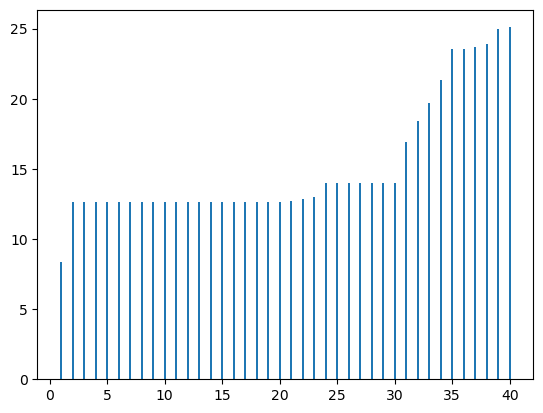

In [52]:
import matplotlib.pyplot as plt
data1 = ec_worker.tp[:,:,:]
data2 = ec_worker.tp[:,:,:]
lon = 121.42
lat = 28.62
value = data1
y = value.sel(lonS=lon, latS=lat,method='nearest').to_pandas().tolist()
x = [i for i in range(len(y))]
plt.bar(x,y,width = 0.2)

<BarContainer object of 41 artists>

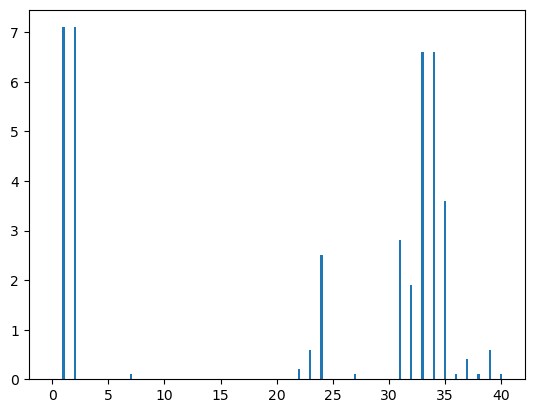

In [49]:
import matplotlib.pyplot as plt
x = [i for i in range(len(data[0]['cp']))]
y1 = data[0]['cp']
y2 = data[0]['tp'] + data[0]['cp']
y3 = data[0]['t2']
ysum = [i + j for i, j in zip(y1, y2)]
plt.bar(x,ysum,width = 0.2)


In [ ]:
# 检验数据的正确性

In [30]:
data1 = ec_worker.tp[1,:,:]
data2 = ec_worker.tp[2,:,:]
lon = 121.42
lat = 28.62
value = data2-data1
value.sel(lonS=lon, latS=lat,method='nearest')

<xarray.DataArray 'tp' ()>
array(4.30365, dtype=float32)
Coordinates:
    lonS     float32 121.4
    latS     float32 28.62

<xarray.DataArray 'tp' (latS: 57, lonS: 65)>
array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-13.551914  , -13.918182  ,  -9.065136  , ...,  -0.18313599,
         -0.18313599,  -0.09156799],
       [ -7.233795  , -10.16394   ,  -6.867523  , ...,  -0.18313599,
         -0.09156799,  -0.09156799],
       [ -9.4314    ,  -8.607292  ,  -7.6000633 , ...,  -0.36627197,
         -0.27470016,  -0.18313217]], dtype=float32)
Coordinates:
  * lonS     (lonS) float32 115.0 115.1 115.2 115.4 ... 122.6 122.8 122.9 123.0
  * latS     (latS) float32 33.0 32.88 32.75 32.62 ... 26.38 26.25 26.12 26.0

In [22]:
lon = 121.42
lat = 28.62
data.sel(lonS=lon, latS=lat,method='nearest')

<xarray.DataArray 'tp' ()>
array(25.08936, dtype=float32)
Coordinates:
    lonS     float32 121.4
    latS     float32 28.62
    time     int64 240
Attributes:
    units:      mm
    long_name:  Total precipitation (Accumulated)